In [11]:
import numpy as np
import pandas as pd

out = 'PROPERTY: HV'
outs = ['PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)']

input_df = pd.read_csv('../../MPEA_dataset_with_error.csv')
input_df = pd.read_csv('../../MPEA_dataset.csv')

input_df.keys()

Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title'],
      dtype='object')

In [2]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

def featurize(df, out):
    df = df.dropna(subset=[out])
    df = StrToComposition().featurize_dataframe(df, "FORMULA", ignore_errors=True)
    ep_feat = ElementProperty.from_preset(preset_name="magpie")
    df = ep_feat.featurize_dataframe(df, col_id="composition", ignore_errors=True)
    df = pd.get_dummies(df, columns=['PROPERTY: Processing method', 'PROPERTY: Type of test'])
    return df

In [3]:
from lolopy.learners import RandomForestRegressor
#from sklearn.ensemble import RandomForestRegressor


def train_and_predict(df, out):
    
    t_dept = ['PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)', 'PROPERTY: Elongation plastic (%)',]
    
    if out in t_dept:
        features = [x for x in df.keys() if 'Magpie' in x] + [x for x in df.keys() if 'PROPERTY: Processing method_' in x] + ['PROPERTY: Test temperature ($^\circ$C)', 'PROPERTY: Type of test_C', 'PROPERTY: Type of test_T']
    else:
        features = [x for x in df.keys() if 'Magpie' in x] + [x for x in df.keys() if 'PROPERTY: Processing method_' in x]
    
    df = df.dropna(subset=features+[out])
    print('Training rows:', len(df), out)

    X = df[features].values
    y = df[out].values

    rf = RandomForestRegressor()
    rf.fit(X, y)
    y_pred, y_pred_loss = rf.predict(X, return_std=True)
    print('Predictions: ', y_pred[0], y_pred_loss[0])

    df[out+'_pred'] = y_pred.round(1)
    df[out+'_pred_loss'] = y_pred_loss.round(1)
    return df

In [4]:
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, accuracy_score



def predict_through_cv(df, out):
    
    t_dept = ['PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)', 'PROPERTY: Elongation plastic (%)',]
    
    if out in t_dept:
        features = [x for x in df.keys() if 'Magpie' in x] + [x for x in df.keys() if 'PROPERTY: Processing method_' in x] + ['PROPERTY: Test temperature ($^\circ$C)', 'PROPERTY: Type of test_C', 'PROPERTY: Type of test_T']
    else:
        features = [x for x in df.keys() if 'Magpie' in x] + [x for x in df.keys() if 'PROPERTY: Processing method_' in x]

    df = df.dropna(subset=features+[out])
    print('Training rows:', len(df), out)

    X = df[features].values
    y = df[out].values
    
    rf = RandomForestRegressor()
    #rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    kf = KFold(n_splits=5)
    
    y_pred = np.zeros(len(df))
    y_pred_loss = np.zeros(len(df))
    y_act = np.zeros(len(df))
    gtmes = []
    rmses = []
    
    for train, test in kf.split(X, y):
        print("PROP: ", out, "TRAIN:", len(train), "TEST:", len(test))

        # fit model
        rf.fit(X[train], y[train])
        
        y_p, y_p_std = rf.predict(X[test], return_std=True)
        
        y_pred[test] = y_p
        y_pred_loss[test] = y_p_std
        y_act[test] = y[test]

        gtme = np.std(y[test])
    #         gtme = np.std(y)
        rmse = mean_squared_error(y[test], y_p)**0.5

        gtmes.append(gtme)
        rmses.append(rmse)
        
    df[out+'_pred'] = y_pred.round(1)
    df[out+'_pred_loss'] = y_pred_loss.round(1)
    df[out] = y_act

    ndmes = np.array(rmses)/np.array(gtmes) 
    print('avg. GTME: {}'.format(np.mean(gtmes)))
    print('avg. RMSE: {}'.format(np.mean(rmses)))
    print('avg. NDME: {}'.format(np.mean(ndmes)))
    
    return df


In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"

def plot(df, out):
    df = df.sort_values(out+'_pred_loss', ascending=False)

    fig = make_subplots(rows=1, cols=2, subplot_titles=[out, out], specs=[[{"type": "scatter"}, {"type": "table"}]], column_widths=[0.8,1.2])
    
    #fig.add_trace(go.Histogram(x=df[out], nbinsx=30),row=1, col=1)
    fig.add_trace(go.Scatter(x=[0, df[out].max()], y=[0, df[out].max()], mode='lines'))
    fig.add_trace(go.Scatter(x=df[out], y=df[out+'_pred'], error_y=dict(array=df[out+'_pred_loss'], color='DarkSlateGrey'), hovertext=df['FORMULA'], mode='markers'))

    fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
    
    fig.update_layout(font=dict(family="Barlow Semi Condensed", size=24), width=2000, height=1000, showlegend=False)
    
    print("headers: ", out, out+'_pred', out+'_pred_loss',)
    table = go.Table(header=dict(values=['FORMULA', out, out+'_pred', out+'_pred_loss', 'DOI'], font=dict(size=16)), columnwidth=[160, 60, 60, 60, 160],
                     cells=dict(values=[df['FORMULA'], df[out], df[out+'_pred'], df[out+'_pred_loss'], df["REFERENCE: doi"]], font=dict(size=16)))


    fig.add_trace(table, row=1, col=2)
    fig.update_xaxes(title_text=out, row=1, col=1)
    fig.update_yaxes(title_text='Counts', row=1, col=1)
    
    fig.update_xaxes(title_text='actual', row=1, col=2)
    fig.update_yaxes(title_text='predicted', row=1, col=2)
    


    fig.show()
    
    return None



Training rows: 1066 PROPERTY: YS (MPa)
Predictions:  213.12443000089343 216.11369121747848
headers:  PROPERTY: YS (MPa) PROPERTY: YS (MPa)_pred PROPERTY: YS (MPa)_pred_loss


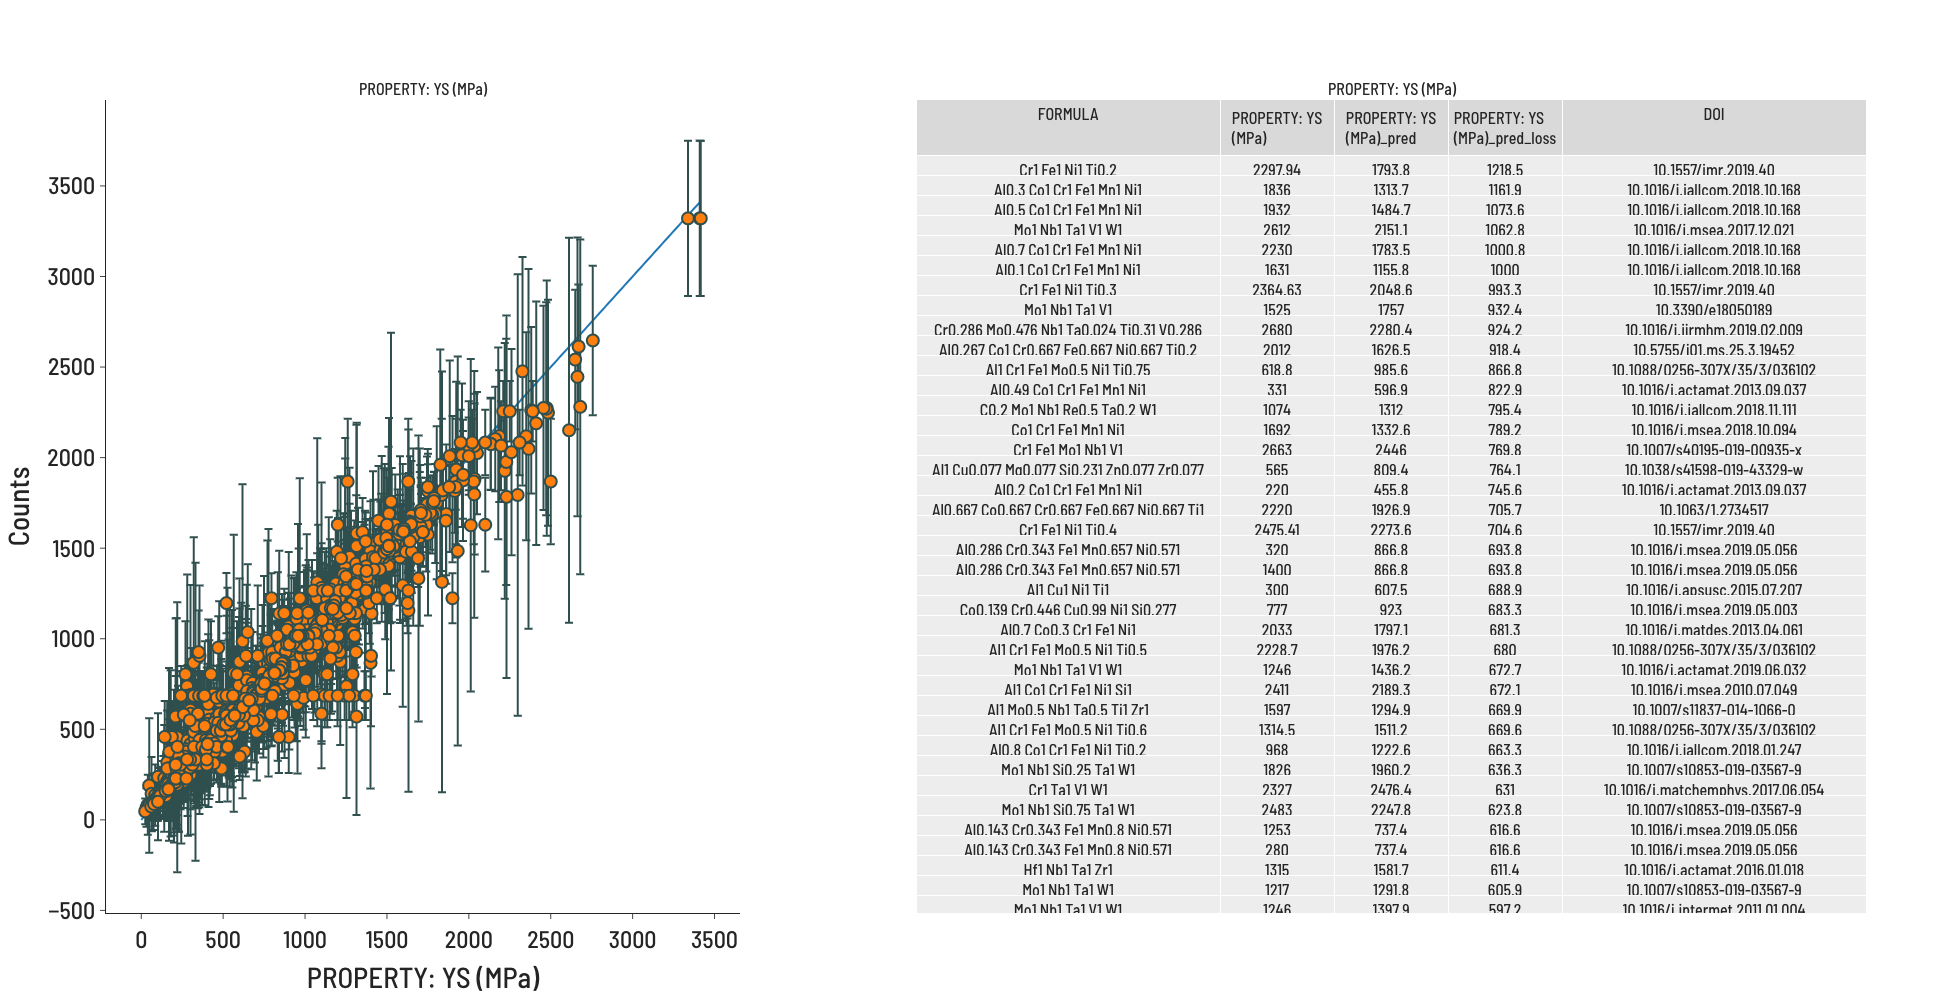

In [13]:
out = 'PROPERTY: YS (MPa)'
df = featurize(input_df, out)
df = train_and_predict(df, out)
#df = predict_through_cv(df, out)
plot(df, out)

In [25]:
import plotly
plotly.offline.init_notebook_mode()